In [ ]:
#src == 來源圖物件
#dst == 目標/輸出圖物件

#邊緣檢測函數
#cv2.CV_8U == dtype: np.uint8
#cv2.Laplacian(src, dtype, dst, K值)

#cv2.Sobel(src, dtype, dx, dy) 
# x,y兩軸需要分開作, 即dx=1的時候dy=0
#且dtype必須是cv2.CV_16S, 因Sobel計算結果會超出0~255的區間, 不能用cv2.CV_8U
#之後還需要透過cv2.convertScaleAbs()把dtype轉換回cv2.CV_8U, 否則不能正確顯示圖片
#最後用cv2.addWeighted(x, x的weight, y, y的weight, gamma值)將拆開計算的結果組合回去
#x kernel = [[-1, 0, 1], 
#           [-2, 0, 2],
#           [-1, 0, 1]]
#y kernel = [[-1,-2,-1],
#            [ 0, 0, 0],
#            [ 1, 2, 1]]

#cv2.Scharr() #尚未讀過
#以上的邊緣檢測容易被噪點誤導, 需要自己先模糊化/去噪/二值化等過程後才做檢測
#cv2.Canny(src, treshold1, treshold2) #最省事的方法,自帶去噪,使用double treshold剔除false positive,檢測並消除不明顯邊緣

#模糊化函數, K越大越模糊
#cv2.Blur(圖物件, K值) #簡單模糊
#cv2.medianBlur(圖物件, K值) #中位數模糊,對處理影片雜訊點較有效,特別是彩色影像
#cv2.GaussianBlur(圖物件, K值) #高斯模糊

#cv2.filter2D(src, dtype, kernel, dst) #卷積濾波器, 可自訂kernel
#dtype若為-1表示src與dst用相同的dtype
#filter2D對3通道都使用同一個kernel
#若要對不同通道使用不同kernel, 需要先用cv2.split(src)分離通道處理過, 在用cv2.merge(通道,dst)

In [20]:
import cv2
import numpy as np
import utils
import scipy.interpolate

#模糊化>灰階>Laplacian邊緣檢測
#src輸入的圖物件, dst輸出的圖物件
#封裝成filters.py

def strokeEdges(src, dst, blurKsize, edgeKsize):  #邊緣檢測 + 描繪邊緣
    if blurKsize >= 3:
        blurredSrc = cv2.medianBlur(src, blurKsize)
        graySrc = cv2.cvtColor(blurredSrc, cv2.COLOR_BGR2GRAY)
    else:
        graySrc = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    cv2.Laplacian(graySrc, cv2.CV_8U, graySrc, ksize = edgeKsize) #Laplacian邊緣檢測
    normalizedInverseAlpha = (1.0/255)*(255-graySrc) # 正規化, 修正成0~1之間的float, 當weight使用
    channels = cv2.split(src) #將通道分離
    for channel in channels:
        channel[:] = channel * normalizedInverseAlpha
    output = cv2.merge(channels, dst) #將通道組合回去
    return output

class VConvolutionFilter(object):   #作卷積
    # A filter that applies a convolution to V (or all of BGR).
    def __init__(self, kernel):
        self._kernel = kernel
        
    def apply(self, src, dst):      
        #Apply the filter with a BGR or gray source/destination.
        cv2.filter2D(src, -1, self._kernel, dst)   #指定kernel作卷積

class SharpenFilter(VConvolutionFilter):
    #A sharpen filter with a 1-pixel radius.
    def __init__(self):
        #銳利化的kernel,
        kernel = np.array([
                [-1,-1,-1],
                [-1, 9,-1],
                [-1,-1,-1],
            ])
        VConvolutionFilter.__init__(self, kernel)
        
class FindEdgesFilter(VConvolutionFilter):
    #An edge-finding filter with 1-pixel radius.
    def __init__(self):
        #銳利化的kernel, 但令總和為0, 這會導致像素點與鄰近點通道值相近的變為黑色
        kernel = np.array([
                    [-1,-1,-1],
                    [-1, 8,-1],
                    [-1,-1,-1],
                ])
        VConvolutionFilter.__init__(self, kernel)
        
class BlurFilter(VConvolutionFilter):
    #A blur filter with a 2-pixel radius.
    def __init__(self):
        #模糊化的kernel, 總合為1且全為正數
        kernel = np.array([
                [0.04,0.04,0.04,0.04,0.04],
                [0.04,0.04,0.04,0.04,0.04],
                [0.04,0.04,0.04,0.04,0.04],
                [0.04,0.04,0.04,0.04,0.04],
                [0.04,0.04,0.04,0.04,0.04],
                ])
        VConvolutionFilter.__init__(self, kernel)
        
class EmbossFilter(VConvolutionFilter):
    #An emboss filter with a 1-pixel radius.
     def __init__(self):
            #浮雕化, 左上角銳利化並右下角模糊化
        kernel = np.array([
                    [-2,-1, 0],
                    [-1, 1, 1],
                    [ 0, 1, 2],
                ])
        VConvolutionFilter.__init__(self, kernel)


In [ ]:

def createCurveFunc(points):
    """Return a function derived from control points."""
    if points is None:
        return None
    numPoints = len(points)
    if numPoints < 2:
        return None
    xs, ys = zip(*points)
    if numPoints < 4:
        kind = 'linear'
        # 'quadratic' is not implemented.
    else:
        kind = 'cubic'
    return scipy.interpolate.interp1d(xs, ys, kind, bounds_error = False)

def createLookupArray(func, length = 256):
    """Return a lookup for whole-number inputs to a function.
    
    The lookup values are clamped to [0, length - 1].
    
    """
    if func is None:
        return None
    lookupArray = np.empty(length)
    i = 0
    while i < length:
        func_i = func(i)
        lookupArray[i] = min(max(0, func_i), length - 1)
        i += 1
    return lookupArray

def applyLookupArray(lookupArray, src, dst):
    """Map a source to a destination using a lookup."""
    if lookupArray is None:
        return
    dst[:] = lookupArray[src]

def createCompositeFunc(func0, func1):
    """Return a composite of two functions."""
    if func0 is None:
        return func1
    if func1 is None:
        return func0
    return lambda x: func0(func1(x))
        
class BGRFuncFilter(object):
    """A filter that applies different functions to each of BGR."""
    
    def __init__(self, vFunc = None, bFunc = None, gFunc = None, rFunc = None, dtype = np.uint8):
        length = np.iinfo(np.uint8).max + 1
        self._bLookupArray = createLookupArray(createCompositeFunc(bFunc, vFunc), length)
        self._gLookupArray = createLookupArray(createCompositeFunc(gFunc, vFunc), length)
        self._rLookupArray = createLookupArray(createCompositeFunc(rFunc, vFunc), length)
    
    def apply(self, src, dst):
        """Apply the filter with a BGR source/destination."""
        b, g, r = cv2.split(src)
        utils.applyLookupArray(self._bLookupArray, b, b)
        utils.applyLookupArray(self._gLookupArray, g, g)
        utils.applyLookupArray(self._rLookupArray, r, r)
        cv2.merge([b, g, r], dst)

class BGRCurveFilter(BGRFuncFilter):
    """A filter that applies different curves to each of BGR."""
    
    def __init__(self, vPoints = None, bPoints = None, gPoints = None, rPoints = None, dtype = np.uint8):
        BGRFuncFilter.__init__(self,
                               createCurveFunc(vPoints),
                               createCurveFunc(bPoints),
                               createCurveFunc(gPoints),
                               createCurveFunc(rPoints), dtype = dtype)      
        
class BGRPortraCurveFilter(BGRCurveFilter):
    """A filter that applies Portra-like curves to BGR."""
    
    def __init__(self, dtype = np.uint8):
        BGRCurveFilter.__init__(
            self,
            vPoints = [(0,0),(23,20),(157,173),(255,255)],
            bPoints = [(0,0),(41,46),(231,228),(255,255)],
            gPoints = [(0,0),(52,47),(189,196),(255,255)],
            rPoints = [(0,0),(69,69),(213,218),(255,255)], dtype = dtype)

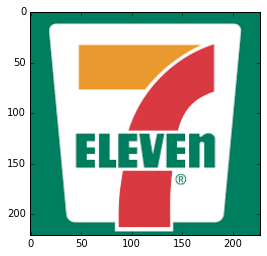

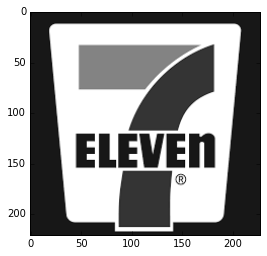

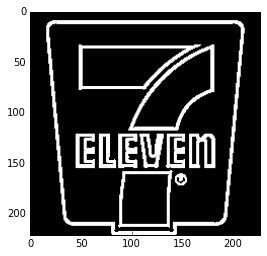

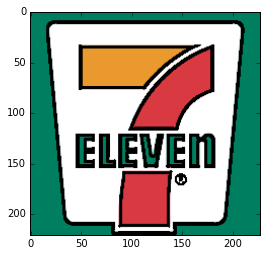

In [62]:
#strokeEdges的分段測試
from matplotlib import pyplot as plt
%matplotlib inline
path = '7-11-logo-2.png'
src = cv2.imread(path) #原圖
src_RGB = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
plt.imshow(src_RGB)
plt.show()

blurredSrc = cv2.medianBlur(src, 1) #模糊化+灰階
graySrc = cv2.cvtColor(blurredSrc, cv2.COLOR_BGR2GRAY)
plt.imshow(graySrc, 'gray')
plt.show()

cv2.Laplacian(graySrc, cv2.CV_8U, graySrc, 7) #Laplacian邊緣檢測
plt.imshow(graySrc, 'gray')
plt.show()

normalizedInverseAlpha = (1.0/255)*(255-graySrc)
#print normalizedInverseAlpha

channels = cv2.split(src)
#print channels

for channel in channels:
    channel[:] = channel * normalizedInverseAlpha
#    print channel
dst = cv2.merge(channels, src)

#dst = strokeEdges(src, src, 7, 7)
dst_RGB = cv2.cvtColor(dst,cv2.COLOR_BGR2RGB)
plt.imshow(dst_RGB)
plt.show()


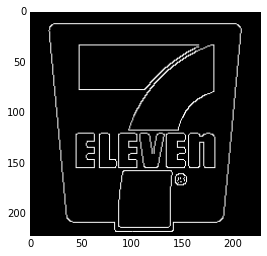

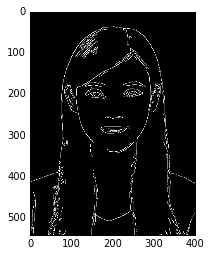

In [83]:
path = '7-11-logo-2.png'
src = cv2.imread(path) #原圖
dst = cv2.Canny(src, 200, 300) #用Canny邊緣檢測
plt.imshow(dst, 'gray')
plt.show()

path = 'face.jpg'
src = cv2.imread(path)
dst = cv2.Canny(src, 100, 200) #用Canny
plt.imshow(dst, 'gray')
plt.show()

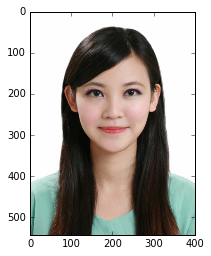

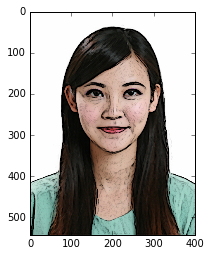

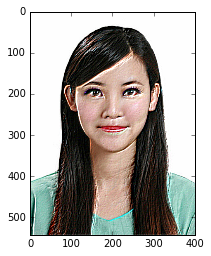

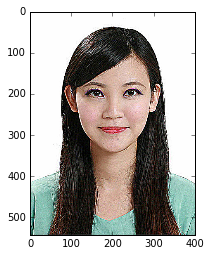

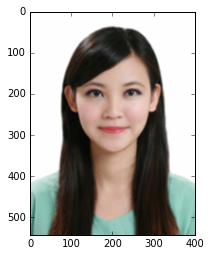

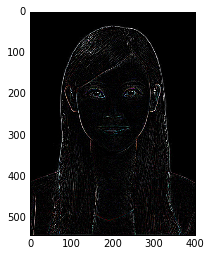

In [77]:
from matplotlib import pyplot as plt
%matplotlib inline

path = 'face.jpg'
src = cv2.imread(path) #原圖
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.show()

strokeEdges(src, src, 7, 5)
BGRPortraCurveFilter(src)   #卡通化
src_RGB = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
plt.imshow(src_RGB)
plt.show()

src = cv2.imread(path)
EmbossFilter().apply(src, src)  #浮雕化
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.show()

src = cv2.imread(path)
SharpenFilter().apply(src, src) #銳利化
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.show()

src = cv2.imread(path)
BlurFilter().apply(src, src)  #模糊化
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.show()

src = cv2.imread(path)
FindEdgesFilter().apply(src, src)  #自製的簡易邊緣檢測
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.show()

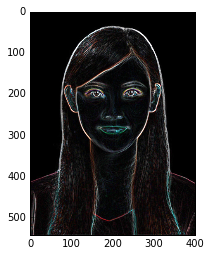

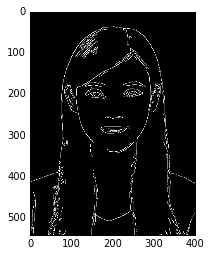

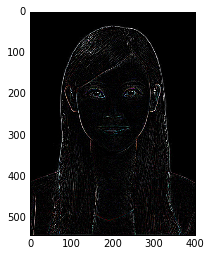

In [98]:
path = 'face.jpg'
src = cv2.imread(path)
x = cv2.Sobel(src,cv2.CV_16S,1,0)  #Sobel邊緣檢測
y = cv2.Sobel(src,cv2.CV_16S,0,1)
absX = cv2.convertScaleAbs(x)
absY = cv2.convertScaleAbs(y)
dst = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB), 'gray')
plt.show()

src = cv2.imread(path)
dst = cv2.Canny(src, 100, 200) #Canny邊緣檢測
plt.imshow(dst, 'gray')
plt.show()

src = cv2.imread(path)
FindEdgesFilter().apply(src, src)  #自製的簡易邊緣檢測
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.show()

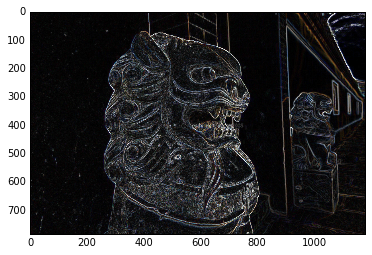

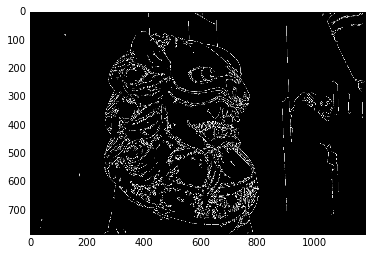

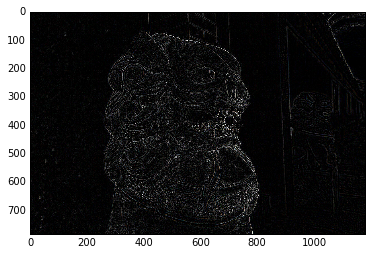

In [106]:
path = 'testimage.jpg'
src = cv2.imread(path)
x = cv2.Sobel(src,cv2.CV_16S,1,0)  #Sobel邊緣檢測
y = cv2.Sobel(src,cv2.CV_16S,0,1)
absX = cv2.convertScaleAbs(x)
absY = cv2.convertScaleAbs(y)
dst = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB), 'gray')
plt.show()

src = cv2.imread(path)
dst = cv2.Canny(src, 100, 300) #Canny邊緣檢測
plt.imshow(dst, 'gray')
plt.show()

src = cv2.imread(path)
FindEdgesFilter().apply(src, src)  #自製的簡易邊緣檢測
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.show()